In [10]:
from miniai.img_plotting import *
from miniai.training import *
from miniai.conv import *
import torch, torch.nn as nn, torch.nn.functional as F
from torch import tensor, optim
from torch.utils.data import DataLoader
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl

mpl.rcParams['image.cmap'] = 'Greys'
torch.set_printoptions(precision=2, linewidth=100)

In [11]:
data = pd.read_csv('data/fashion_mnist/train.csv')

In [12]:
X_train = tensor(data.iloc[:50000, 1:].values)
y_train = tensor(data.iloc[:50000, 0].values)
X_valid = tensor(data.iloc[50000:, 1:].values)
y_valid = tensor(data.iloc[50000:, 0].values)

In [13]:
dset_train = Dataset((X_train/255. ).view(-1, 1, 28, 28), y_train)
dset_valid = Dataset((X_valid/255. ).view(-1, 1, 28, 28), y_valid)

In [14]:
dl_train = DataLoader(dset_train, batch_size=64, shuffle=True)
dl_valid = DataLoader(dset_valid, batch_size=len(dset_valid), shuffle=False)

<Axes: >

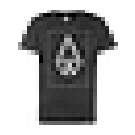

In [20]:
show_image(next(iter(dl_train))[0][0], shape=[28, 28])

<br>**Model**

In [23]:
def deconv(in_f, out_f, ks=3, act=None):
    layers = [
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(in_f, out_f, ks, stride=1, padding=ks//2)
    ]
    if act != None: layers.append(act)
    return nn.Sequential(*layers)

In [35]:
def train_autoencoder(epochs, lr, opt, model, loss_func, dl_train, dl_valid, eval_freq=1):
    for epoch in range(epochs):
        # Loop through batches
        loss_sum, cnt = 0, 0
        for X_b, y_b in dl_train:
            # Get the gradients by calculating the loss
            preds = model(X_b)
            loss = loss_func(preds, X_b)
            loss.backward()
            # For model evaluation
            with torch.no_grad(): 
                loss_sum += loss.item(); cnt += 1
            # Update the weights
            opt.step()
            opt.zero_grad()
        # Evaluate the model
        if epoch%eval_freq == 0: 
            train_loss = loss_sum/cnt; loss_sum, cnt = 0, 0;
            for X_b, y_b in dl_valid:
                with torch.no_grad():
                    preds = model(X_b)
                    loss_sum += loss_func(preds, X_b).item(); cnt += 1
            valid_loss = loss_sum/cnt 
            print(f'{train_loss:.4f}\t{valid_loss:.4f}')

In [47]:
model = nn.Sequential(
    conv(1, 4, act=nn.ReLU()), #14×14
    conv(4, 8, act=nn.ReLU()), #7×7
    conv(8, 16, act=nn.ReLU()), #4×4
    deconv(16, 8, act=nn.ReLU()), #8×8
    deconv(8, 4, act=nn.ReLU()), #16×16
    deconv(4, 1, act=nn.ReLU()), #32×32
    nn.ZeroPad2d(-2), #28×28
)

In [62]:
lr = 6e-3
opt = optim.Adam(model.parameters(), lr)
train_autoencoder(3, lr, opt, model, F.l1_loss, dl_train, dl_valid)

0.0535	0.0521
0.0521	0.0522
0.0518	0.0582


In [63]:
X_b = next(iter(dl_valid))[0][:10]

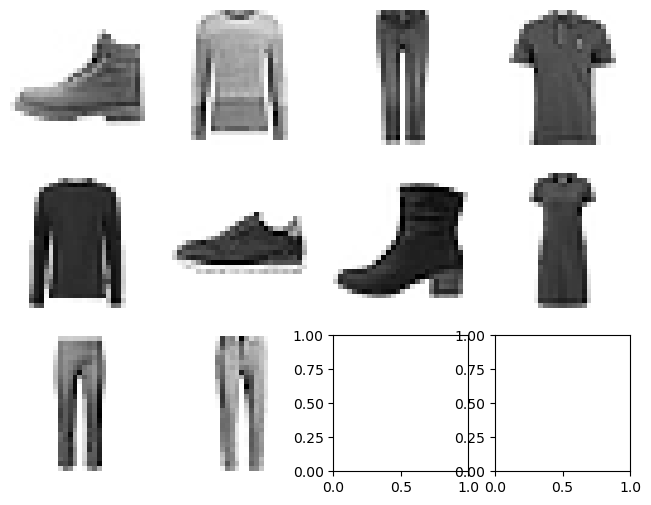

In [66]:
show_images([X_b[i] for i in range(X_b.shape[0])], shape=[28, 28], n=X_b.shape[0])

In [64]:
X_b.shape

torch.Size([10, 1, 28, 28])

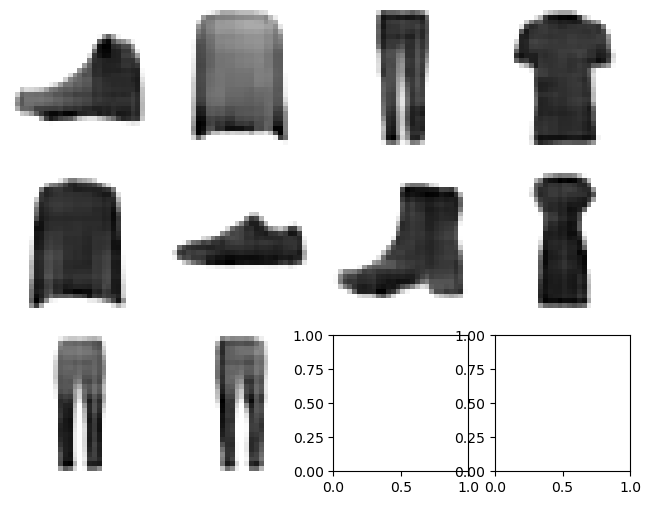

In [65]:
with torch.no_grad(): preds = model(X_b)
show_images([preds[i] for i in range(preds.shape[0])], shape=[28, 28], n=preds.shape[0])

In [61]:
show_images??